## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.activations import sigmoid
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, average_precision_score

## Do some early processing of your metadata for easier model training:

In [62]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
26786,00007008_006.png,No Finding,6,7008,36,M,AP,2940,2544,0.139,0.139,NaN,/data/images_004/images/00007008_006.png
89821,00022304_001.png,No Finding,1,22304,31,M,PA,2500,2048,0.168,0.168,NaN,/data/images_010/images/00022304_001.png
98781,00026112_002.png,Effusion|Infiltration|Pleural_Thickening,2,26112,56,M,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00026112_002.png


In [63]:
## Remove rows with unreal ages.
print(len(all_xray_df))
all_xray_df = all_xray_df[(all_xray_df['Patient Age']>0) & (all_xray_df['Patient Age']<100)]
print(len(all_xray_df), max(all_xray_df['Patient Age']), min(all_xray_df['Patient Age']))

112120
112104 95 1


In [64]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = list(set(chain.from_iterable([x.split('|') for x in all_xray_df['Finding Labels']])))
all_labels

['Effusion',
 'Hernia',
 'Cardiomegaly',
 'Consolidation',
 'Pneumothorax',
 'Pneumonia',
 'No Finding',
 'Fibrosis',
 'Edema',
 'Mass',
 'Nodule',
 'Infiltration',
 'Pleural_Thickening',
 'Emphysema',
 'Atelectasis']

In [65]:
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if label in x else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pneumonia,No Finding,Fibrosis,Edema,Mass,Nodule,Infiltration,Pleural_Thickening,Emphysema,Atelectasis
2682,00000710_002.png,No Finding,2,710,57,F,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54613,00013670_120.png,Infiltration|Mass,120,13670,56,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
45543,00011683_027.png,Effusion|Emphysema,27,11683,58,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [66]:
all_xray_df['Patient Gender'].value_counts(normalize=True)

M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64

In [67]:
sum(all_xray_df['Pneumonia']==1.0)

1430

In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
# all_xray_df['Pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 1.0 if x == 1.0 else 0.0)
## I already have a "Pneumonia" column for images with or without pneumonia.

## Create your training and testing data:

In [68]:
def create_splits(data,
                  features=None,
                  train_size=0.8,
                  random_state=42,
                  shuffle=True):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(data,
                                            train_size=train_size,
                                            random_state=random_state,
                                            shuffle=shuffle,
                                            stratify=features)
    return train_data, val_data

In [89]:
cols = ['path', 'Pneumonia', 'Patient Gender', 'Patient Age', 'View Position']
simple_xray_df = all_xray_df[cols]
simple_xray_df.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
73762,/data/images_008/images/00018137_002.png,0.0,F,55,AP
55675,/data/images_007/images/00013925_002.png,0.0,M,37,AP
14974,/data/images_002/images/00003916_003.png,0.0,M,19,PA


In [90]:
train_data, val_data = create_splits(simple_xray_df, all_xray_df['Pneumonia'])
len(train_data), len(val_data)

(89683, 22421)

In [91]:
train_data.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
33715,/data/images_004/images/00008841_037.png,0.0,F,50,PA
47976,/data/images_006/images/00012158_002.png,0.0,F,51,AP
19714,/data/images_003/images/00005241_001.png,0.0,F,58,PA


In [92]:
val_data.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
62629,/data/images_007/images/00015514_000.png,0.0,M,36,PA
49671,/data/images_006/images/00012613_002.png,0.0,M,66,PA
35085,/data/images_005/images/00009256_002.png,0.0,F,55,AP


In [93]:
## Make sure the appearance probability is equal in training and validation dataset.
assert round(sum(train_data['Pneumonia']==1.0)/len(train_data), 4) == round(sum(val_data['Pneumonia']==1.0)/len(val_data), 4), "Appearance probabilities in training dataset and validation dataset are different"

In [94]:
sum(train_data['Pneumonia']==1.0)/len(train_data), sum(val_data['Pneumonia']==1.0)/len(val_data)

(0.012756040721206917, 0.01275589848802462)

In [95]:
## Because the probability of Pneumonia in raw dataset is not 50%. So we need to handle this unbalanced datasets.
p_idx = train_data[train_data['Pneumonia']==1.0].index.tolist()
np_idx = train_data[train_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx))
train_data_50 = train_data.loc[p_idx + np_sample]
len(train_data_50), (sum(train_data_50['Pneumonia']==1.0)/len(train_data_50))

(2288, 0.5)

In [96]:
p_idx = val_data[val_data['Pneumonia']==1.0].index.tolist()
np_idx = val_data[val_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx)*4)
val_data_20 = val_data.loc[p_idx + np_sample]
len(val_data_20), (sum(val_data_20['Pneumonia'])/len(val_data_20))

(1430, 0.2)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [97]:
def my_image_augmentation(rotation_range=0.0,
                          width_shift_range=0.0,
                          height_shift_range=0.0,
                          shear_range=0.0,
                          zoom_range=0.0,
                          horizontal_flip=False,
                          vertical_flip=False,
                          validation_split=0.0,
                          rescale=1./255.0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rotation_range=rotation_range,
                                width_shift_range=width_shift_range,
                                height_shift_range=height_shift_range,
                                shear_range=shear_range,
                                zoom_range=zoom_range,
                                horizontal_flip=horizontal_flip,
                                vertical_flip=vertical_flip,
                                validation_split=validation_split,
                                rescale=rescale)
    return my_idg


def make_train_gen(my_train_idg,
                   train_df,
                   x_col,
                   y_col,
                   class_mode='binary',
                   target_size=(224, 224),
                   batch_size=22):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df,
                                                 directory=None,
                                                 x_col=x_col,
                                                 y_col=y_col,
                                                 class_mode=class_mode,
                                                 target_size=target_size,
                                                 batch_size=batch_size)
    return train_gen


def make_val_gen(my_val_idg,
                 val_df,
                 x_col,
                 y_col,
                 class_mode='binary',
                 target_size=(224, 224),
                 batch_size=22):
    # Todo
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col=x_col,
                                             y_col=y_col,
                                             class_mode=class_mode,
                                             target_size=target_size, 
                                             batch_size=batch_size) 
    return val_gen

In [98]:
my_train_idg=my_image_augmentation(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15)
my_val_idg=my_image_augmentation()

In [99]:
train_data_50['Pneumonia']=train_data_50['Pneumonia'].astype('str')
train_gen=make_train_gen(my_train_idg=my_train_idg,
                         train_df=train_data_50,
                         x_col='path',
                         y_col='Pneumonia')
val_data_20['Pneumonia']=val_data_20['Pneumonia'].astype('str')
val_gen=make_val_gen(my_val_idg=my_val_idg,
                     val_df=val_data_20,
                     x_col='path',
                     y_col='Pneumonia')

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [100]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [101]:
valY

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0.], dtype=float32)

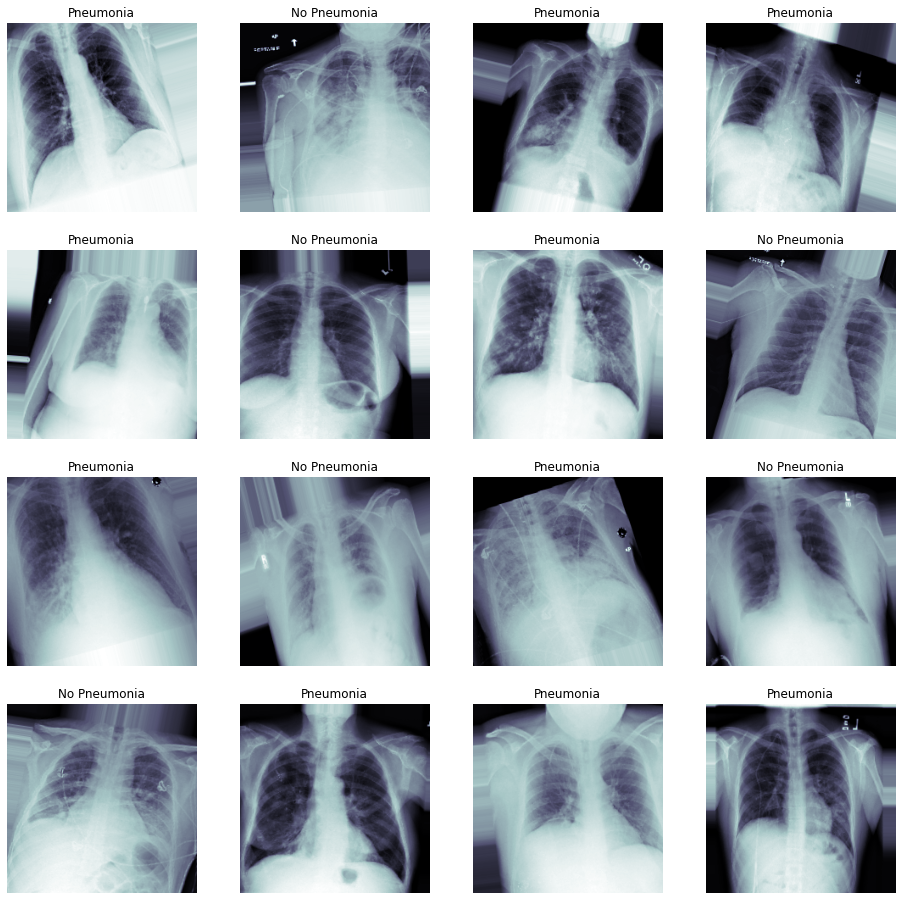

In [102]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [103]:
VGG16(include_top=True, weights='imagenet').summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [104]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model=VGG16(include_top=True, weights='imagenet')
    transfer_layer=model.get_layer('block5_pool')
    vgg_model=Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[:-2]:
        layer.trainable = False
    return vgg_model


In [105]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model=load_pretrained_model()
    my_model=Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [106]:
model_50 = build_my_model()
model_50.compile(loss='binary_crossentropy',
                 optimizer=Adam(lr=0.001),
                 metrics=['binary_accuracy'])
model_50.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)              

In [107]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class_50')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [108]:
## train your model

# Todo

history = model_50.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
104/104 [==============================] - 63s 605ms/step - loss: 0.8046 - binary_accuracy: 0.5192 - val_loss: 0.6564 - val_binary_accuracy: 0.8636

Epoch 00001: val_loss improved from inf to 0.65638, saving model to xray_class_50_my_model.best.hdf5
Epoch 2/20
104/104 [==============================] - 60s 572ms/step - loss: 0.6919 - binary_accuracy: 0.5358 - val_loss: 0.7100 - val_binary_accuracy: 0.4091

Epoch 00002: val_loss did not improve from 0.65638
Epoch 3/20
104/104 [==============================] - 62s 601ms/step - loss: 0.6884 - binary_accuracy: 0.5428 - val_loss: 0.7300 - val_binary_accuracy: 0.2273

Epoch 00003: val_loss did not improve from 0.65638
Epoch 4/20
104/104 [==============================] - 61s 590ms/step - loss: 0.6778 - binary_accuracy: 0.5839 - val_loss: 0.7406 - val_binary_accuracy: 0.0909

Epoch 00004: val_loss did not improve from 0.65638
Epoch 5/20
104/104 [==============================] - 63s 606ms/step - loss: 0.6879 - binary_accuracy: 0.5

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [109]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
weight_path='xray_class_50_my_model.best.hdf5'
model_50.load_weights(weight_path)
pred_Y = model_50.predict(valX, batch_size = 32, verbose = True)


22/22 [==============================] - 0s 18ms/step


In [110]:
pred_Y_binary = [1 if i[0] > 0.5 else 0 for i in pred_Y]

In [111]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
#Also consider plotting the history of your model training:

def plot_history(history, kind):
    '''
    kind: either "accuracy" or "loss"
    '''
    plt.figure(figsize = (9, 9))
    kind = 'binary_accuracy' if kind == 'accuracy' else kind
    plt.plot(history.history[f'val_{kind}'], label=f'validation {kind}')
    plt.plot(history.history[f'{kind}'], label=f'training {kind}')
    plt.title(f'Validation/Training {kind}')
    plt.ylabel('EPOCHS')
    plt.legend()
    plt.show()
    
    return


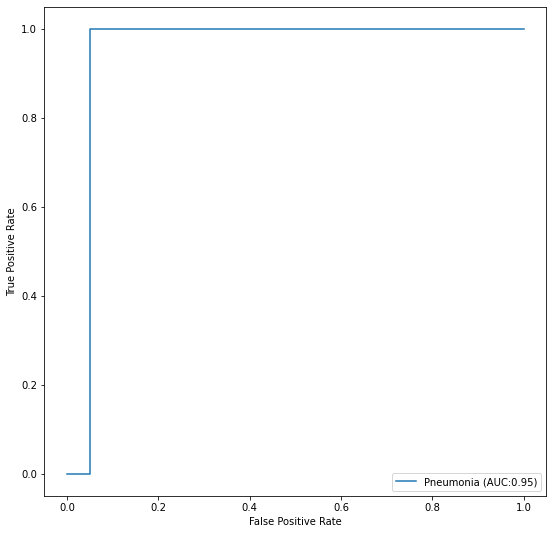

In [112]:
## plot figures

# Todo
plot_auc(valY, pred_Y)

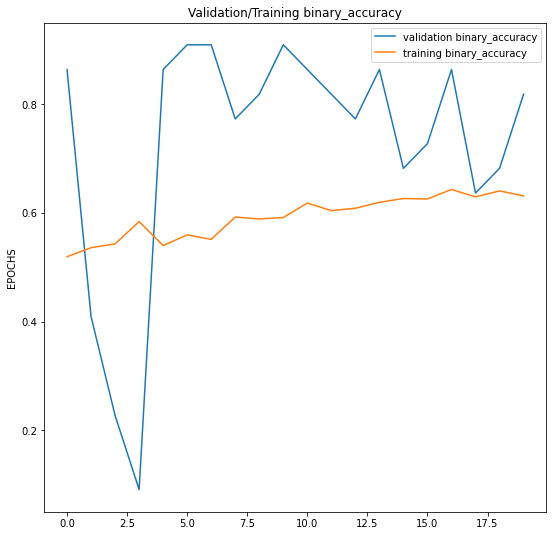

In [113]:
plot_history(history, 'accuracy')

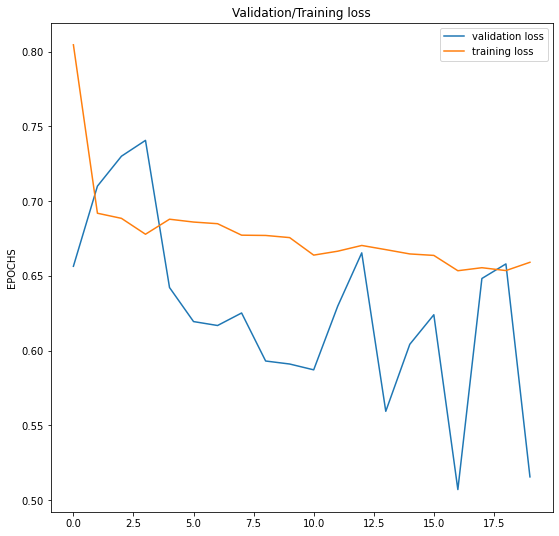

In [114]:
plot_history(history, 'loss')

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [115]:
confusion_matrix(pred_Y_binary, valY)

array([[17,  0],
       [ 3,  2]])

In [116]:
pred_Y, max(pred_Y), min(pred_Y)

(array([[0.34787738],
        [0.48807916],
        [0.5305775 ],
        [0.34787738],
        [0.34787738],
        [0.34787738],
        [0.34787738],
        [0.34787738],
        [0.34787738],
        [0.34787738],
        [0.6538054 ],
        [0.34787738],
        [0.34787738],
        [0.6546369 ],
        [0.34787738],
        [0.34787738],
        [0.34787738],
        [0.35270396],
        [0.61357915],
        [0.34787738],
        [0.34787738],
        [0.59444696]], dtype=float32),
 array([0.6546369], dtype=float32),
 array([0.34787738], dtype=float32))

In [117]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
thresholds = [0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    pred_Y_custom = [1 if pred>t else 0 for pred in pred_Y]
    print(confusion_matrix(pred_Y_custom, valY))
    tn, fp, fn, tp = confusion_matrix(pred_Y_custom, valY).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    print("Precision: "+str(precision))
    print("recall: "+str(recall))
    print("Specificity: "+str(tn/(tn+fp)))
    print("F1: "+str(2*(precision*recall)/(precision+recall)))
    print("-------------------------------------")

[[ 0  0]
 [20  2]]
Precision: 1.0
recall: 0.09090909090909091
Specificity: nan
F1: 0.16666666666666669
-------------------------------------
[[16  0]
 [ 4  2]]
Precision: 1.0
recall: 0.3333333333333333
Specificity: 1.0
F1: 0.5
-------------------------------------
[[17  0]
 [ 3  2]]
Precision: 1.0
recall: 0.4
Specificity: 1.0
F1: 0.5714285714285715
-------------------------------------
[[19  0]
 [ 1  2]]
Precision: 1.0
recall: 0.6666666666666666
Specificity: 1.0
F1: 0.8
-------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


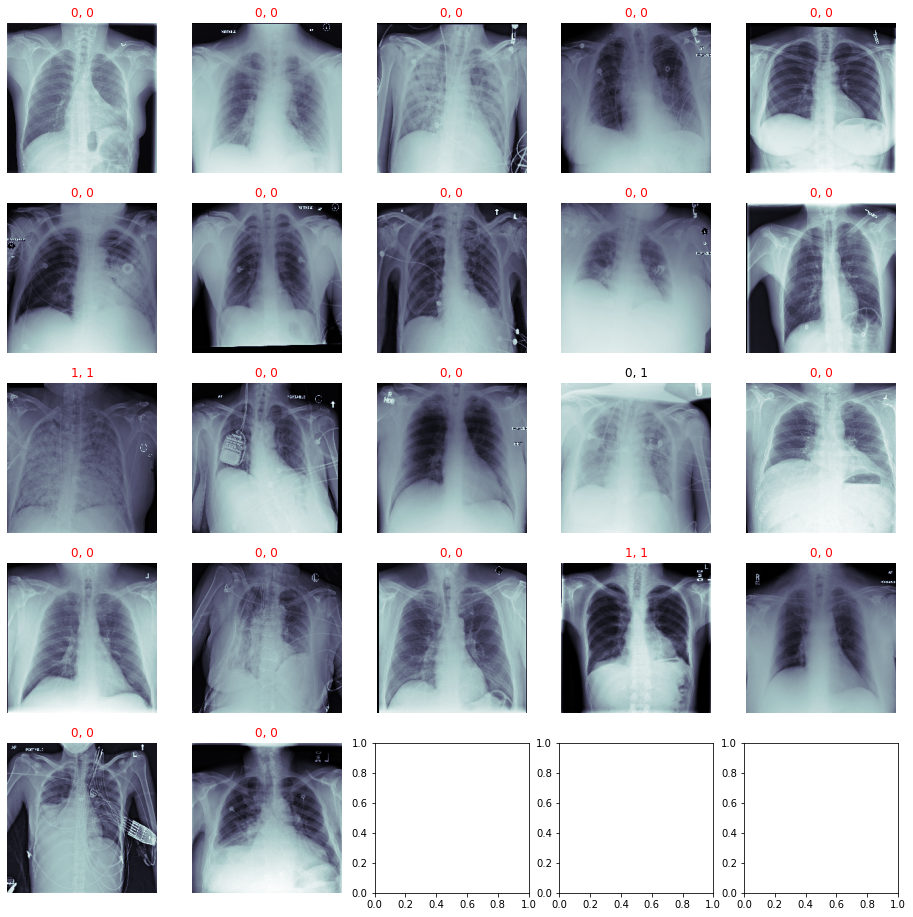

In [119]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.6:
            c_ax.set_title('1, 1', color='r')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.6: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0', color='r')
    c_ax.axis('off')
    i=i+1

In [120]:
## Just save model architecture to a .json:

model_json = model_50.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# I am little curious that what if I remove some confusion diseases. Maybe i could get better result

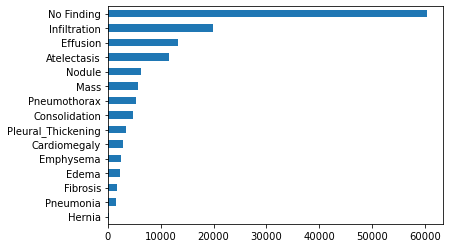

In [123]:
all_xray_df[all_labels].sum().nlargest(15).sort_values().plot(kind='barh')

### Based on the EDA result before, 'Consolidation', 'Infiltration', and 'Mass' are the most three confusion diseases compare to Pneumonia

In [128]:
less_xray_df = all_xray_df[(all_xray_df['Consolidation']!=1) & (all_xray_df['Infiltration']!=1) & (all_xray_df['Mass']!=1)]
less_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pneumonia,No Finding,Fibrosis,Edema,Mass,Nodule,Infiltration,Pleural_Thickening,Emphysema,Atelectasis
11162,00002895_000.png,Atelectasis|Pleural_Thickening,0,2895,59,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
51049,00012903_000.png,No Finding,0,12903,51,F,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83807,00020595_003.png,No Finding,3,20595,62,M,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16856,00004526_002.png,Cardiomegaly,2,4526,43,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94156,00023956_000.png,No Finding,0,23956,23,F,PA,2682,2377,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
len(less_xray_df)

84593

In [130]:
less_xray_df['Pneumonia'].sum()

712.0

In [131]:
simple_less_xray_df = less_xray_df[cols]
simple_less_xray_df.sample(3)

,path,Pneumonia,Patient Gender,Patient Age,View Position
98088,/data/images_011/images/00025887_000.png,0.0,M,34,PA
6908,/data/images_002/images/00001836_094.png,0.0,F,50,AP
102075,/data/images_011/images/00027189_001.png,0.0,M,60,AP


In [133]:
train_data, val_data = create_splits(simple_less_xray_df, simple_less_xray_df['Pneumonia'])
len(train_data), len(val_data)

(67674, 16919)

In [140]:
p_idx = train_data[train_data['Pneumonia']==1.0].index.tolist()
np_idx = train_data[train_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx))
train_data_50 = train_data.loc[p_idx + np_sample]
len(train_data_50), (sum(train_data_50['Pneumonia']==1.0)/len(train_data_50))

(1140, 0.5)

In [141]:
p_idx = val_data[val_data['Pneumonia']==1.0].index.tolist()
np_idx = val_data[val_data['Pneumonia']==0.0].index.tolist()
np_sample = random.sample(np_idx, len(p_idx)*4)
val_data_20 = val_data.loc[p_idx + np_sample]
len(val_data_20), (sum(val_data_20['Pneumonia'])/len(val_data_20))

(710, 0.2)

In [142]:
my_train_idg=my_image_augmentation(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15)
my_val_idg=my_image_augmentation()

In [144]:
train_data_50['Pneumonia']=train_data_50['Pneumonia'].astype('str')
train_gen=make_train_gen(my_train_idg=my_train_idg,
                         train_df=train_data_50,
                         x_col='path',
                         y_col='Pneumonia')
val_data_20['Pneumonia']=val_data_20['Pneumonia'].astype('str')
val_gen=make_val_gen(my_val_idg=my_val_idg,
                     val_df=val_data_20,
                     x_col='path',
                     y_col='Pneumonia')

Found 1140 validated image filenames belonging to 2 classes.
Found 710 validated image filenames belonging to 2 classes.


In [145]:
valX, valY = val_gen.next()

In [146]:
## Since we got less data this turn, I would like to reduce the number of layers
def build_my_model2():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model=load_pretrained_model()
    my_model=Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model

In [147]:
model_50 = build_my_model2()
model_50.compile(loss='binary_crossentropy',
                 optimizer=Adam(lr=0.001),
                 metrics=['binary_accuracy'])
model_50.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [149]:
weight_path="{}_my_model.best.hdf5".format('xray_class_50_less')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [150]:
history = model_50.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
52/52 [==============================] - 31s 605ms/step - loss: 0.7122 - binary_accuracy: 0.5140 - val_loss: 0.7007 - val_binary_accuracy: 0.2727

Epoch 00001: val_loss improved from inf to 0.70070, saving model to xray_class_50_less_my_model.best.hdf5
Epoch 2/20
52/52 [==============================] - 30s 572ms/step - loss: 0.6978 - binary_accuracy: 0.4965 - val_loss: 0.6937 - val_binary_accuracy: 0.3636

Epoch 00002: val_loss improved from 0.70070 to 0.69368, saving model to xray_class_50_less_my_model.best.hdf5
Epoch 3/20
52/52 [==============================] - 30s 572ms/step - loss: 0.6949 - binary_accuracy: 0.5193 - val_loss: 0.6829 - val_binary_accuracy: 0.6364

Epoch 00003: val_loss improved from 0.69368 to 0.68285, saving model to xray_class_50_less_my_model.best.hdf5
Epoch 4/20
52/52 [==============================] - 30s 575ms/step - loss: 0.6965 - binary_accuracy: 0.4825 - val_loss: 0.6996 - val_binary_accuracy: 0.3636

Epoch 00004: val_loss did not improve from

In [151]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
weight_path='xray_class_50_less_my_model.best.hdf5'
model_50.load_weights(weight_path)
pred_Y = model_50.predict(valX, batch_size = 32, verbose = True)

22/22 [==============================] - 0s 18ms/step


In [152]:
pred_Y_binary = [1 if i[0] > 0.5 else 0 for i in pred_Y]

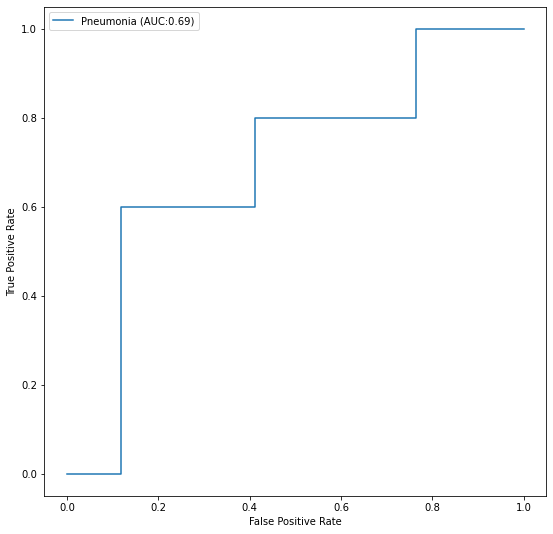

In [153]:
plot_auc(valY, pred_Y)

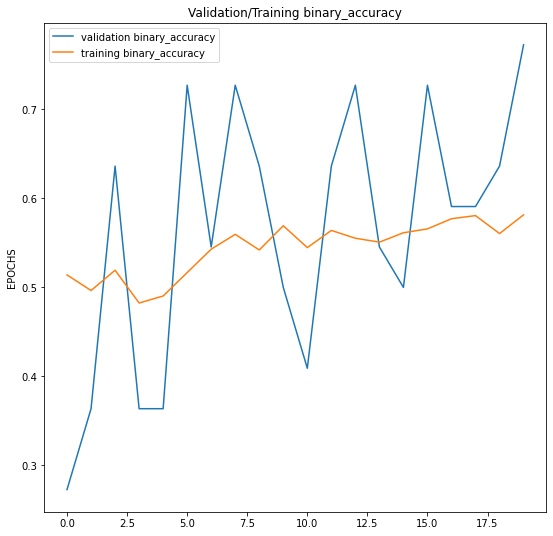

In [154]:
plot_history(history, 'accuracy')

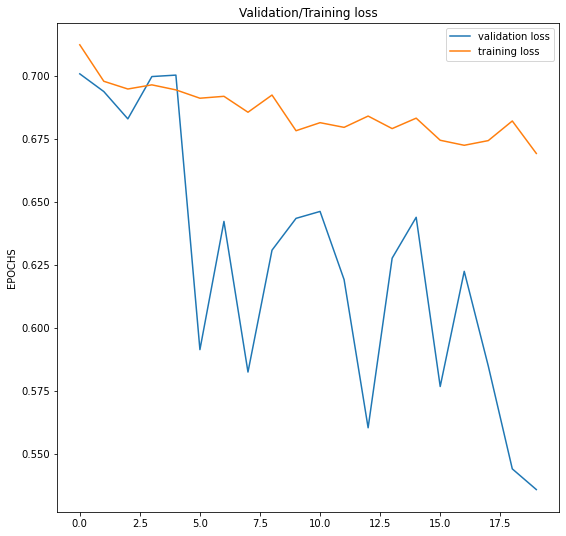

In [155]:
plot_history(history, 'loss')

In [156]:
confusion_matrix(pred_Y_binary, valY)

array([[14,  2],
       [ 3,  3]])

In [157]:
pred_Y, max(pred_Y), min(pred_Y)

(array([[0.08167093],
        [0.4692579 ],
        [0.16173485],
        [0.20939633],
        [0.45606783],
        [0.55615574],
        [0.42004266],
        [0.5122597 ],
        [0.5227879 ],
        [0.45159614],
        [0.27327776],
        [0.43379402],
        [0.07027774],
        [0.00240203],
        [0.52481097],
        [0.34941068],
        [0.15519604],
        [0.54607314],
        [0.03416156],
        [0.1140102 ],
        [0.6546583 ],
        [0.27495036]], dtype=float32),
 array([0.6546583], dtype=float32),
 array([0.00240203], dtype=float32))

In [158]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    pred_Y_custom = [1 if pred>t else 0 for pred in pred_Y]
    print(confusion_matrix(pred_Y_custom, valY))
    tn, fp, fn, tp = confusion_matrix(pred_Y_custom, valY).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    print("Precision: "+str(precision))
    print("recall: "+str(recall))
    print("Specificity: "+str(tn/(tn+fp)))
    print("F1: "+str(2*(precision*recall)/(precision+recall)))
    print("-------------------------------------")

[[ 4  0]
 [13  5]]
Precision: 1.0
recall: 0.2777777777777778
Specificity: 1.0
F1: 0.4347826086956522
-------------------------------------
[[ 6  1]
 [11  4]]
Precision: 0.8
recall: 0.26666666666666666
Specificity: 0.8571428571428571
F1: 0.4
-------------------------------------
[[9 1]
 [8 4]]
Precision: 0.8
recall: 0.3333333333333333
Specificity: 0.9
F1: 0.47058823529411764
-------------------------------------
[[10  1]
 [ 7  4]]
Precision: 0.8
recall: 0.36363636363636365
Specificity: 0.9090909090909091
F1: 0.5000000000000001
-------------------------------------
[[14  2]
 [ 3  3]]
Precision: 0.6
recall: 0.5
Specificity: 0.875
F1: 0.5454545454545454
-------------------------------------
[[16  5]
 [ 1  0]]
Precision: 0.0
recall: 0.0
Specificity: 0.7619047619047619
F1: nan
-------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


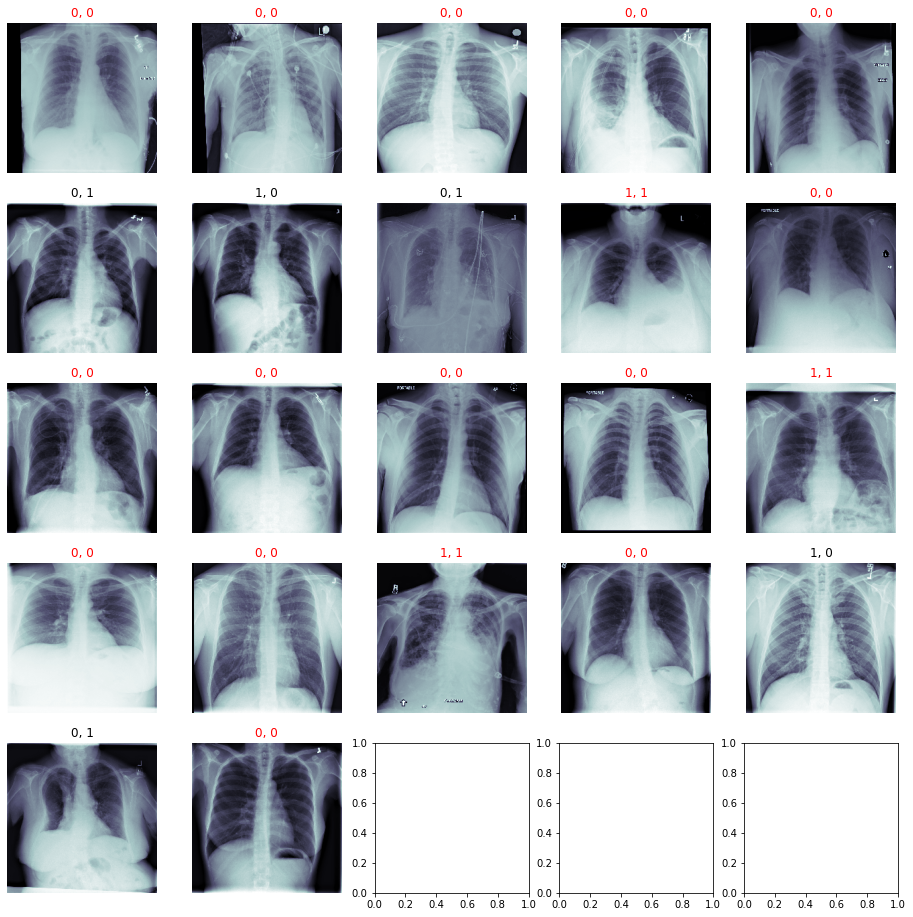

In [159]:
fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.5:
            c_ax.set_title('1, 1', color='r')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.5: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0', color='r')
    c_ax.axis('off')
    i=i+1

In [ ]:
## So, unfortunately, the result become worse than previous. I w